In [11]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from adjustText import adjust_text 
import pickle 
import math
import scanpy as sc
import pandas as pd
from scipy import sparse

In [12]:
unshuffled = sc.read_h5ad("/gpfs/home/asun/jin_lab/perturbench/data/boli_perturb_ctx_edit_ntsubset_hvg/raw/adata.h5ad")

In [13]:
shuffled = sc.read_h5ad("/gpfs/home/asun/jin_lab/perturbench/data/boli_perturb_ctx_edit_ntsubset_hvg/processed/shuffled_assign/adata.h5ad")

In [14]:
sc.pp.neighbors(unshuffled, use_rep="X_hvg")
sc.tl.umap(unshuffled)

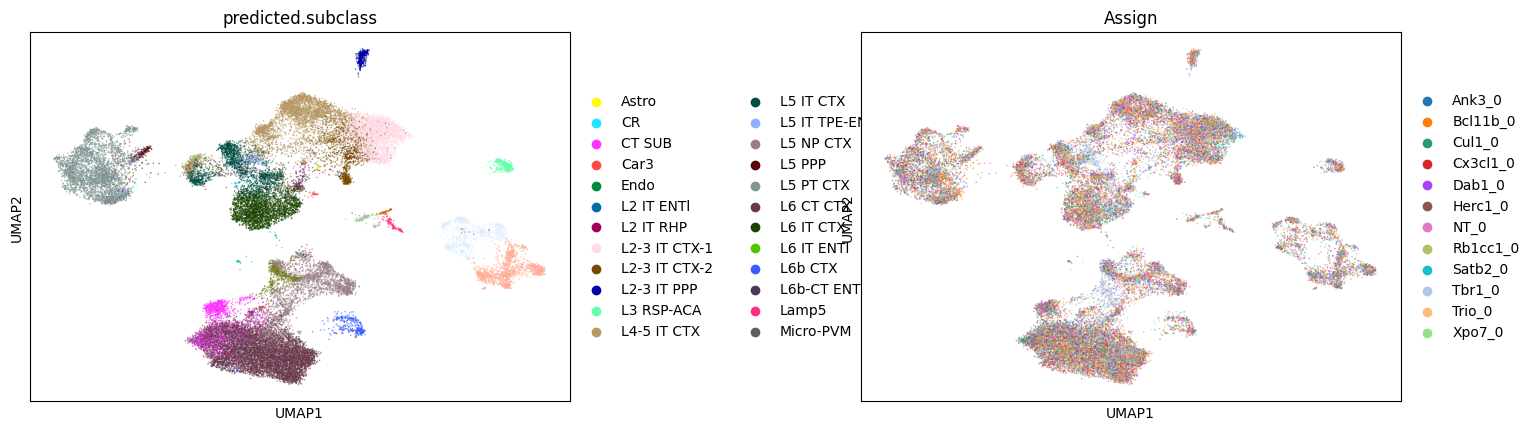

In [15]:
# UMAP colored by cell type and perturbation
sc.pl.umap(
    unshuffled,
    color=["predicted.subclass", "Assign"],
    wspace=0.4,        # spacing between panels
    size=5,            # point size
    alpha=0.6,         # point transparency
)

In [17]:
df

,predicted.subclass,Assign,UMAP1,UMAP2
0,L5 PT CTX,Bcl11b_0,-6.684904,10.701364
1,L6b CTX,Bcl11b_0,4.924580,-2.130351
2,CT SUB,Bcl11b_0,-2.574735,-2.269201
3,L5 PT CTX,Xpo7_0,-8.621343,12.209466
4,L6b CTX,Xpo7_0,4.975467,-1.624007
...,...,...,...,...
33033,L5 IT TPE-ENT,Tbr1_0,0.440230,10.703250
33034,L6 IT CTX,Rb1cc1_0,0.315598,7.191899
33035,L5 PT CTX,Bcl11b_0,-6.836094,11.367890
33036,L6 CT CTX,Rb1cc1_0,2.042614,-3.615921


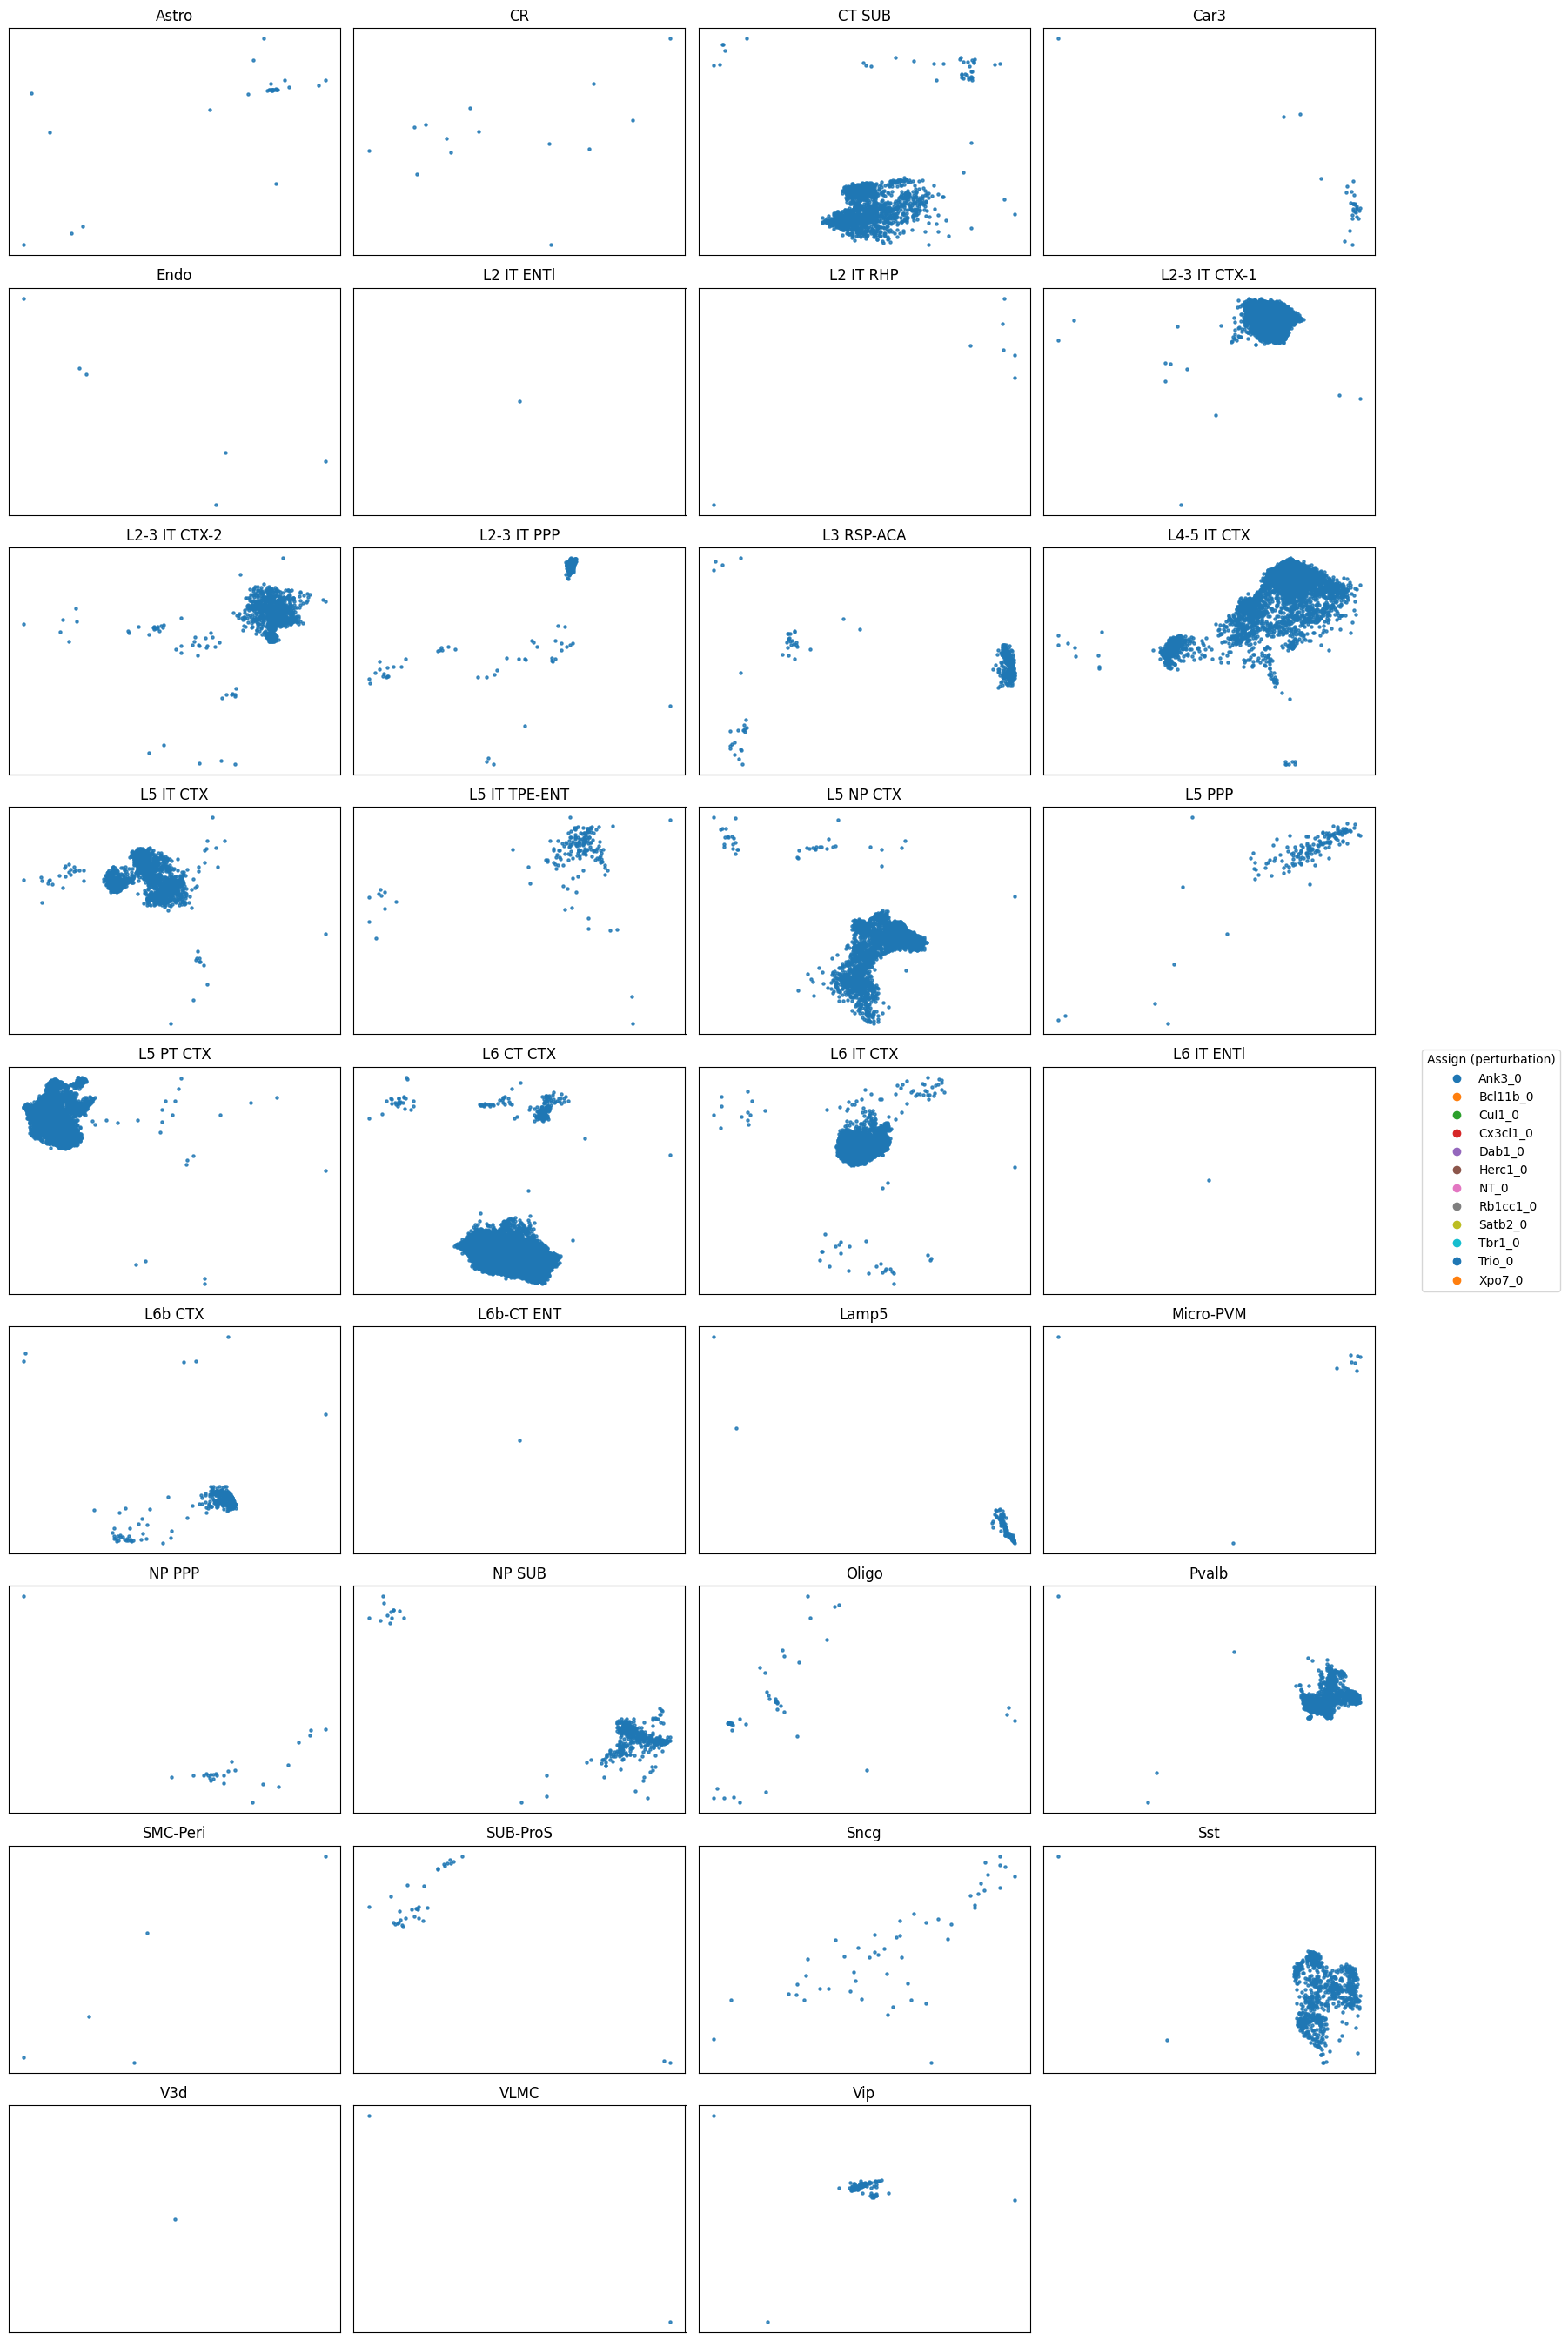

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

#----------------------------------------------------
# 1) Ensure we have a UMAP embedding
#----------------------------------------------------
if "X_umap" not in unshuffled.obsm:
    # You can tweak neighbors / PCA etc. as you like
    sc.pp.neighbors(unshuffled)
    sc.tl.umap(unshuffled)

umap = unshuffled.obsm["X_umap"]

# Build a DataFrame with UMAP + obs
df = unshuffled.obs[["predicted.subclass", "Assign"]].copy()
df["UMAP1"] = umap[:, 0]
df["UMAP2"] = umap[:, 1]

df = df.reset_index(drop=True)
# Make sure categories are well defined / ordered
df["predicted.subclass"] = df["predicted.subclass"].astype("category")
df["Assign"] = df["Assign"].astype("category")

cell_types = df["predicted.subclass"].cat.categories
perturbations = df["Assign"].cat.categories

#----------------------------------------------------
# 2) Color palette for perturbations
#----------------------------------------------------
palette = dict(
    zip(perturbations, sns.color_palette(n_colors=len(perturbations)))
)

#----------------------------------------------------
# 3) Faceted UMAP: one panel per cell type
#----------------------------------------------------
n_ct = len(cell_types)
ncols = 4    # adjust if you prefer a different layout
nrows = int(np.ceil(n_ct / ncols))

fig, axes = plt.subplots(
    nrows,
    ncols,
    figsize=(4 * ncols, 3 * nrows),
    squeeze=False
)

for ax, ct in zip(axes.flatten(), cell_types):
    # Cells of this cell type, colored by perturbation
    sub = df[df["predicted.subclass"] == ct]
    ax.scatter(
        sub["UMAP1"],
        sub["UMAP2"],
        s=5,
        alpha=0.8,
        c=sub["Assign"].map(palette),
        rasterized=True,
    )

    ax.set_title(str(ct))
    ax.set_xticks([])
    ax.set_yticks([])

# Hide unused axes if cell_types doesn't fill the grid
for ax in axes.flatten()[len(cell_types):]:
    ax.axis("off")

# Shared legend for perturbations
handles = [
    plt.Line2D(
        [], [], marker="o", linestyle="",
        color=palette[p], label=str(p)
    )
    for p in perturbations
]
fig.legend(
    handles=handles,
    title="Assign (perturbation)",
    bbox_to_anchor=(1.02, 0.5),
    loc="center left",
)

plt.tight_layout()
plt.show()

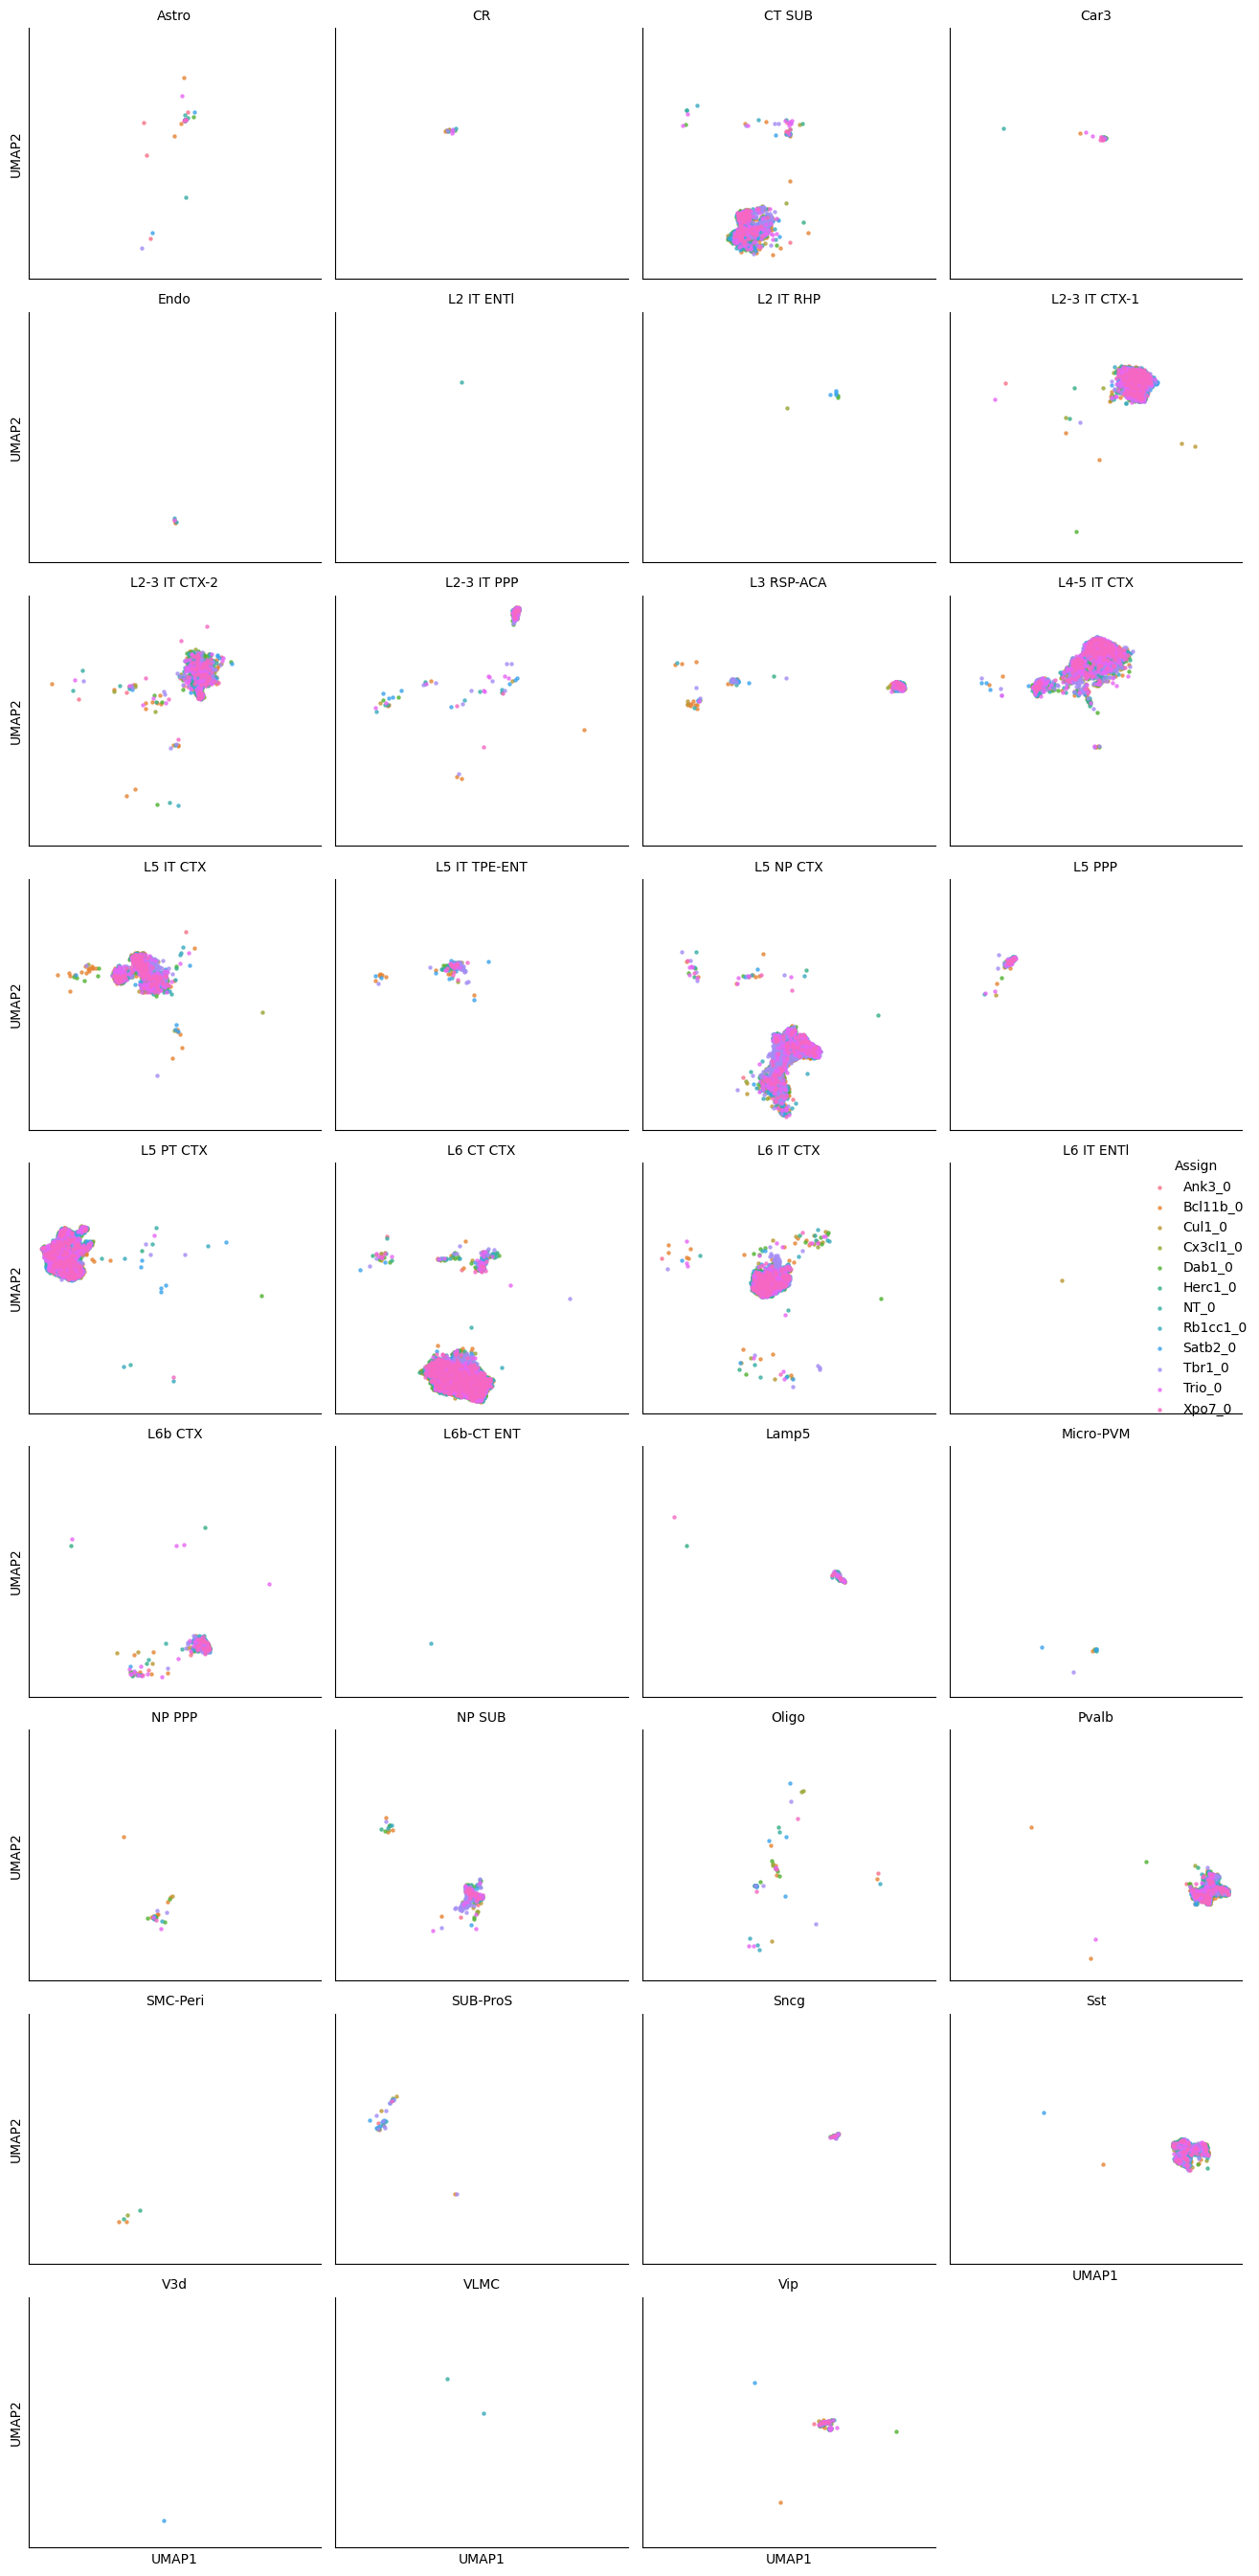

In [22]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1) Make sure UMAP exists
if "X_umap" not in unshuffled.obsm:
    sc.pp.neighbors(unshuffled)          # you can add n_pcs, etc. if needed
    sc.tl.umap(unshuffled)

# 2) Build a flat DataFrame from obs + UMAP
df = unshuffled.obs[["predicted.subclass", "Assign"]].copy()
df["UMAP1"] = unshuffled.obsm["X_umap"][:, 0]
df["UMAP2"] = unshuffled.obsm["X_umap"][:, 1]

# Reset index to avoid MultiIndex issues
df = df.reset_index(drop=True)

# Make sure columns are categorical
df["predicted.subclass"] = df["predicted.subclass"].astype("category")
df["Assign"] = df["Assign"].astype("category")

# 3) Faceted UMAP: one panel per cell type, color = perturbation
g = sns.FacetGrid(
    df,
    col="predicted.subclass",
    col_wrap=4,       # adjust number of panels per row
    hue="Assign",
    sharex=True,
    sharey=True,
    height=3,
)

g.map_dataframe(plt.scatter, "UMAP1", "UMAP2", s=5, alpha=0.7)
g.set_titles(col_template="{col_name}")

# Clean axes
for ax in g.axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

g.add_legend(title="Assign")

plt.tight_layout()
plt.show()